# Lab 2. Part 5. Dogs classification

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/vision/stable/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку.

Требуется добиться accuracy > 93%

## PyTorch models

Models for image classification available in PyTorch:

* AlexNet
* ConvNeXt
* DenseNet
* EfficientNet
* EfficientNetV2
* GoogLeNet
* Inception V3
* MaxVit
* MNASNet
* MobileNet V2
* MobileNet V3
* RegNet
* ResNet
* ResNeXt
* ShuffleNet V2
* SqueezeNet
* SwinTransformer
* VGG
* VisionTransformer
* Wide ResNet

Determining the "best" model from the list depends on various factors, including the specific task, dataset, computational resources, and performance criteria (e.g., accuracy, inference speed, model size). General comparison of these models:

1. **State-of-the-Art Performance**:
   - **SwinTransformer** and **VisionTransformer (ViT)**: These models represent the latest advancements in computer vision, leveraging Transformer architectures, which have proven to be powerful for various vision tasks. SwinTransformer, in particular, has achieved state-of-the-art results in many benchmarks, outperforming many traditional CNNs.

2. **Efficiency and Scalability**:
   - **EfficientNet** and **EfficientNetV2**: EfficientNet models are designed to achieve high accuracy while being highly efficient in terms of parameter count and computational cost. EfficientNetV2 further improves on EfficientNet with faster training times and better performance.
   - **ConvNeXt**: This model combines the strengths of modern CNNs with techniques from Transformer models, offering a good balance between efficiency and performance.

3. **Legacy Models with Strong Performance**:
   - **ResNet** and **ResNeXt**: ResNet (especially deeper versions like ResNet-50, ResNet-101) has been a cornerstone in deep learning, introducing residual connections that made training very deep networks feasible. ResNeXt builds on ResNet by introducing cardinality (the number of independent paths) to improve accuracy.
   - **Inception V3** and **GoogLeNet**: These models introduced innovative architectural concepts like Inception modules, which allow the network to learn from multi-scale features. Inception V3 is particularly well-known for its strong performance on various benchmarks.

4. **Lightweight Models for Mobile/Edge Applications**:
   - **MobileNet V2, V3**: These models are designed for resource-constrained environments, offering a good trade-off between accuracy and model size.
   - **ShuffleNet V2** and **MNASNet**: Similar to MobileNet, these models are optimized for speed and efficiency, making them suitable for mobile and edge devices.

5. **Other Considerations**:
   - **MaxVit**: A relatively newer model that combines convolutions with Vision Transformer blocks, potentially offering strong performance with a balanced architecture.
   - **DenseNet**: Known for its dense connectivity pattern, DenseNet can achieve competitive accuracy with fewer parameters by promoting feature reuse.
   - **VGG**: One of the earlier models that established deep CNN architectures, but now considered less efficient compared to newer models due to its large parameter count.
   - **SqueezeNet**: An extremely lightweight model, designed to be efficient with fewer parameters, making it suitable for very constrained environments.

Summary:

- **Best for Accuracy/Performance**: **SwinTransformer**, **VisionTransformer (ViT)**, **EfficientNetV2**, **ConvNeXt**
- **Best for Efficiency (Mobile/Edge)**: **MobileNet V2/V3**, **EfficientNet**, **ShuffleNet V2**
- **Best for General Use**: **ResNet**, **DenseNet**

If you have access to substantial computational resources and are working on large-scale tasks, **SwinTransformer** or **VisionTransformer** models would likely give you the best performance. If efficiency is a priority, especially for deployment on mobile devices, **EfficientNetV2** or **MobileNet V3** are excellent choices. For a balance of performance, efficiency, and ease of use, **ResNet** models are still a strong go-to option.

### Notes about task

#### Model
Задача предсказания класса изображения, лучше всего использовать архитектуру моделей на сверточных нейронных сетях.  
Буду использовать предобученную модель EfficientNetV2-S и MobileNetV3.  
По идее, просто изменю последний слой на линейный слой с 50 выходами.  

#### Data
Создать PyTorch Dataset для моих данных и DataLoader, чтобы он эффективно подгружал данные в модель. Использовать пайплайны обработки изображений, чтобы потом (если будет недостаточная эффективность модели) добавить туда аугментацию.  
Не забыть нормально разделить датасет на выборки - использовать stratified разделение, чтобы сохранить распределение классов во всех выборках.  
Изучить распределение классов.

#### Loss and metrics
Функция потерь - CrossEntropyLoss.  
Метрики: accuracy, confusion matrix, F1-score (with averaging)

## Imports

In [ ]:
# if using Google Colab
# !pip install torchinfo

In [1]:
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from IPython.display import clear_output
from PIL import Image
from torch.utils.data import DataLoader, Dataset, Subset
from torchinfo import summary
from torchvision.transforms import v2
from tqdm.notebook import tqdm

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

## Params

In [3]:
N_CLASSES = 50
BATCH_SIZE = 64

## Data

### Load from Drive (if using Colab)

In [4]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
!unzip -q /content/drive/MyDrive/data.zip

### Create the Dataset class

We can use the PyTorch `ImageFolder` class (it is doing exaclty the same as below)

In [6]:
class DogBreedsDataset(Dataset):
    """Dog breeds dataset for multi-class classification."""

    def __init__(self, root_dir: Path, transform=None):
        """
        Args:
            root_dir (Path): Directory with images, each class in separate folder.
            transform (callable, optional): Optional transform to be applied on a sample.
                Defaults to None.
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.classes = [d.name for d in self.root_dir.iterdir() if d.is_dir()]

        # create the list of image paths and corresponding labels
        self.image_paths: list[Path] = []
        self.labels: list[int] = []
        for idx, class_name in enumerate(self.classes):
            class_dir = self.root_dir / class_name
            for img_path in class_dir.iterdir():
                if img_path.is_file():
                    self.image_paths.append(img_path)
                    self.labels.append(idx)

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            sample (dict): A dictionary containing the image and the label.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        sample = {"image": image, "label": label}

        return sample


In [7]:
dataset = DogBreedsDataset("/content/data/train")

In [8]:
dataset[0]

{'image': <PIL.Image.Image image mode=RGB size=500x333>, 'label': 0}

In [9]:
len(dataset)

7166

In [10]:
np.bincount(dataset.labels)

array([133, 148, 154, 165, 142, 123, 128, 139, 126, 120, 129, 131, 124,
       123, 174, 129, 174, 169, 143, 125, 252, 137, 128, 139, 123, 122,
       124, 122, 195, 155, 176, 197, 151, 153, 123, 151, 122, 139, 137,
       124, 125, 125, 138, 126, 124, 170, 161, 144, 155, 129])

In [11]:
def sample_random_images(dataset, num_samples=5):
    unique_classes = list(set(dataset.labels))
    sampled_classes = np.random.choice(
        unique_classes, min(num_samples, len(unique_classes)), replace=False
    )

    images = []
    labels = []

    for class_idx in sampled_classes:
        class_image_indices = [
            i for i, label in enumerate(dataset.labels) if label == class_idx
        ]
        sampled_index = np.random.choice(class_image_indices)

        sample = dataset[sampled_index]
        images.append(sample["image"])
        labels.append(sample["label"])

    return images, labels

In [12]:
def show_images(images, labels, class_names):
    plt.figure(figsize=(16, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(v2.ToPILImage()(images[i]))
        plt.title(class_names[labels[i]])
        plt.axis("off")

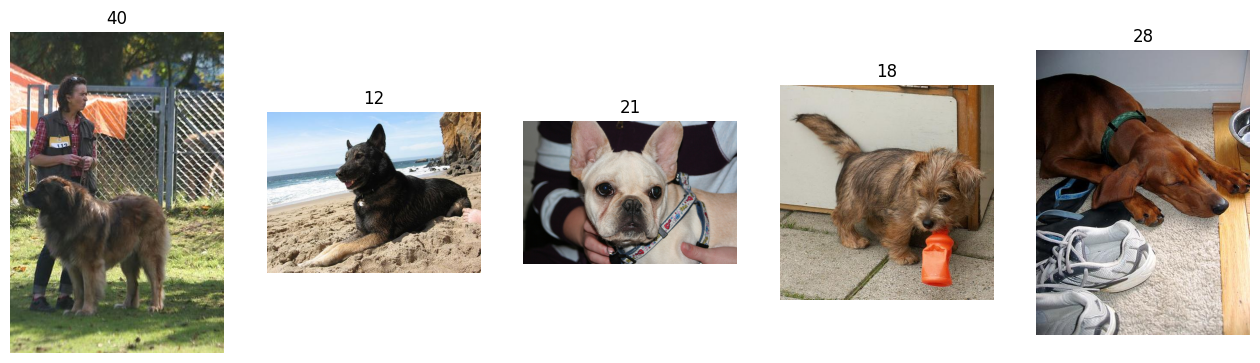

In [13]:
images, labels = sample_random_images(dataset, num_samples=5)
class_names = dataset.classes

show_images(images, labels, class_names)

#### Dataset class for test data

In [53]:
class TestDataset(Dataset):
    def __init__(self, img_dir: Path, transform=None):
        self.img_dir = Path(img_dir)
        self.transform = transform

        # create the list of image paths and corresponding image names
        self.image_paths: list[Path] = []
        self.names: list[str] = []
        for img_path in self.img_dir.iterdir():
            if img_path.is_file():
                self.image_paths.append(img_path)
                self.names.append(img_path.stem)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        name = self.names[idx]

        if self.transform:
            image = self.transform(image)

        sample = {"image": image, "label": name}

        return sample

In [54]:
test_dataset = TestDataset("/content/data/test")

## EfficientNet-V2-S

In [86]:
from torchvision.models import EfficientNet_V2_S_Weights, efficientnet_v2_s

In [87]:
eff_net_weights = EfficientNet_V2_S_Weights.DEFAULT
eff_net = efficientnet_v2_s(weights=eff_net_weights).to(device)

In [88]:
summary(eff_net, (BATCH_SIZE, 3, 100, 100))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [64, 1000]                --
├─Sequential: 1-1                                       [64, 1280, 4, 4]          --
│    └─Conv2dNormActivation: 2-1                        [64, 24, 50, 50]          --
│    │    └─Conv2d: 3-1                                 [64, 24, 50, 50]          648
│    │    └─BatchNorm2d: 3-2                            [64, 24, 50, 50]          48
│    │    └─SiLU: 3-3                                   [64, 24, 50, 50]          --
│    └─Sequential: 2-2                                  [64, 24, 50, 50]          --
│    │    └─FusedMBConv: 3-4                            [64, 24, 50, 50]          5,232
│    │    └─FusedMBConv: 3-5                            [64, 24, 50, 50]          5,232
│    └─Sequential: 2-3                                  [64, 48, 25, 25]          --
│    │    └─FusedMBConv: 3-6                         

In [89]:
for param in eff_net.parameters():
    param.requires_grad = False

In [90]:
eff_net

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [91]:
eff_net.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(256, N_CLASSES),
).to(device)

In [92]:
summary(eff_net, (BATCH_SIZE, 3, 100, 100))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [64, 50]                  --
├─Sequential: 1-1                                       [64, 1280, 4, 4]          --
│    └─Conv2dNormActivation: 2-1                        [64, 24, 50, 50]          --
│    │    └─Conv2d: 3-1                                 [64, 24, 50, 50]          (648)
│    │    └─BatchNorm2d: 3-2                            [64, 24, 50, 50]          (48)
│    │    └─SiLU: 3-3                                   [64, 24, 50, 50]          --
│    └─Sequential: 2-2                                  [64, 24, 50, 50]          --
│    │    └─FusedMBConv: 3-4                            [64, 24, 50, 50]          (5,232)
│    │    └─FusedMBConv: 3-5                            [64, 24, 50, 50]          (5,232)
│    └─Sequential: 2-3                                  [64, 48, 25, 25]          --
│    │    └─FusedMBConv: 3-6                 

In [93]:
eff_net_preprocess = eff_net_weights.transforms()
eff_net_preprocess, eff_net_preprocess.describe()

(ImageClassification(
     crop_size=[384]
     resize_size=[384]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ),
 'Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[384]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[384]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.')

## MobileNet-V3-Large

In [94]:
from torchvision.models import MobileNet_V3_Large_Weights, mobilenet_v3_large

In [95]:
mob_net_weights = MobileNet_V3_Large_Weights.DEFAULT
mob_net = mobilenet_v3_large(weights=mob_net_weights).to(device)

In [96]:
for param in mob_net.parameters():
    param.requires_grad = False

In [97]:
summary(mob_net, (BATCH_SIZE, 3, 100, 100))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [64, 1000]                --
├─Sequential: 1-1                                  [64, 960, 4, 4]           --
│    └─Conv2dNormActivation: 2-1                   [64, 16, 50, 50]          --
│    │    └─Conv2d: 3-1                            [64, 16, 50, 50]          (432)
│    │    └─BatchNorm2d: 3-2                       [64, 16, 50, 50]          (32)
│    │    └─Hardswish: 3-3                         [64, 16, 50, 50]          --
│    └─InvertedResidual: 2-2                       [64, 16, 50, 50]          --
│    │    └─Sequential: 3-4                        [64, 16, 50, 50]          (464)
│    └─InvertedResidual: 2-3                       [64, 24, 25, 25]          --
│    │    └─Sequential: 3-5                        [64, 24, 25, 25]          (3,440)
│    └─InvertedResidual: 2-4                       [64, 24, 25, 25]          --
│    │    └─Sequential

In [98]:
mob_net

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [99]:
mob_net.classifier[3] = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(256, N_CLASSES),
).to(device)

In [100]:
summary(mob_net, (BATCH_SIZE, 3, 100, 100))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [64, 50]                  --
├─Sequential: 1-1                                  [64, 960, 4, 4]           --
│    └─Conv2dNormActivation: 2-1                   [64, 16, 50, 50]          --
│    │    └─Conv2d: 3-1                            [64, 16, 50, 50]          (432)
│    │    └─BatchNorm2d: 3-2                       [64, 16, 50, 50]          (32)
│    │    └─Hardswish: 3-3                         [64, 16, 50, 50]          --
│    └─InvertedResidual: 2-2                       [64, 16, 50, 50]          --
│    │    └─Sequential: 3-4                        [64, 16, 50, 50]          (464)
│    └─InvertedResidual: 2-3                       [64, 24, 25, 25]          --
│    │    └─Sequential: 3-5                        [64, 24, 25, 25]          (3,440)
│    └─InvertedResidual: 2-4                       [64, 24, 25, 25]          --
│    │    └─Sequential

In [101]:
mob_net_preprocess = mob_net_weights.transforms()
mob_net_preprocess, mob_net_preprocess.describe()

(ImageClassification(
     crop_size=[224]
     resize_size=[232]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ),
 'Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[232]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.')

## Preprocessing pipeline

In [21]:
def data_transforms(preprocess):
    transforms = {
        "train": v2.Compose(
            [
                # maybe augmentation...
                # convert to torch tensor
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                # model preprocessing
                preprocess,
            ]
        ),
        "valid": v2.Compose(
            [
                # convert to torch tensor
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                # model preprocessing
                preprocess,
            ]
        ),
    }
    return transforms

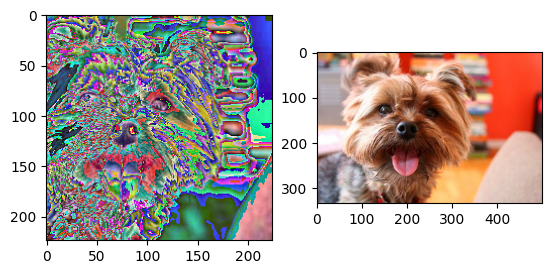

In [22]:
img = data_transforms(mob_net_preprocess)["train"](dataset[10]["image"])
plt.subplot(1, 2, 1)
plt.imshow(v2.ToPILImage()(img))
plt.subplot(1, 2, 2)
plt.imshow(dataset[10]["image"])

## Dataloaders

In [23]:
def stratified_split_indices(labels, train_size=0.8, seed=42):
    """Splits indices into train and validation subsets."""
    label_to_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        label_to_indices[label].append(idx)

    np.random.seed(seed)

    train_ids = []
    valid_ids = []

    for label, ids in label_to_indices.items():
        np.random.shuffle(ids)
        split_point = round(len(ids) * train_size)
        train_ids.extend(ids[:split_point])
        valid_ids.extend(ids[split_point:])

    np.random.shuffle(train_ids)
    np.random.shuffle(valid_ids)

    return train_ids, valid_ids

In [24]:
train_ids, valid_ids = stratified_split_indices(dataset.labels, train_size=0.8, seed=42)

In [25]:
train_dataset = Subset(dataset, train_ids)
valid_dataset = Subset(dataset, valid_ids)

In [26]:
list(map(len, [train_dataset, valid_dataset, dataset]))

[5730, 1436, 7166]

In [27]:
class TransformedDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        # Get the data and label from the original subset
        data = self.subset[index]
        image, label = data["image"], data["label"]

        # Apply transform if provided
        if self.transform:
            image = self.transform(image)

        return {"image": image, "label": label}

    def __len__(self):
        return len(self.subset)

In [73]:
eff_net_train_dataset = TransformedDataset(
    train_dataset, transform=data_transforms(eff_net_preprocess)["train"]
)
eff_net_valid_dataset = TransformedDataset(
    valid_dataset, transform=data_transforms(eff_net_preprocess)["valid"]
)

mob_net_train_dataset = TransformedDataset(
    train_dataset, transform=data_transforms(mob_net_preprocess)["train"]
)
mob_net_valid_dataset = TransformedDataset(
    valid_dataset, transform=data_transforms(mob_net_preprocess)["valid"]
)

In [74]:
eff_net_train_loader = DataLoader(eff_net_train_dataset, BATCH_SIZE, shuffle=True)
eff_net_valid_loader = DataLoader(eff_net_valid_dataset, BATCH_SIZE, shuffle=False)

mob_net_train_loader = DataLoader(mob_net_train_dataset, BATCH_SIZE, shuffle=True)
mob_net_valid_loader = DataLoader(mob_net_valid_dataset, BATCH_SIZE, shuffle=False)

### For test data

In [55]:
len(test_dataset)

1503

In [75]:
eff_net_test_dataset = TransformedDataset(
    test_dataset, transform=data_transforms(eff_net_preprocess)["valid"]
)
mob_net_test_dataset = TransformedDataset(
    test_dataset, transform=data_transforms(mob_net_preprocess)["valid"]
)

In [76]:
eff_net_test_loader = DataLoader(eff_net_test_dataset, BATCH_SIZE, shuffle=False)
mob_net_test_loader = DataLoader(mob_net_test_dataset, BATCH_SIZE, shuffle=False)

## Scripts for saving/loading models

In [31]:
def save_only_trainable_checkpoint(model, opt, epoch, loss_history, path):
    trainable_state_dict = {
        name: param for name, param in model.named_parameters() if param.requires_grad
    }
    checkpoint = {
        "epoch": epoch,
        "trainable_state_dict": trainable_state_dict,
        "optimizer_state_dict": opt.state_dict(),
        "loss_history": loss_history,
    }
    torch.save(checkpoint, path)

In [32]:
def load_only_trainable_checkpoint(model, opt, path):
    checkpoint = torch.load(path, map_location=device)

    model_state_dict = model.state_dict()
    model_state_dict.update(checkpoint["trainable_state_dict"])
    model.load_state_dict(model_state_dict)

    epoch = checkpoint["epoch"]
    loss_history = checkpoint["loss_history"]

    return epoch, loss_history

## Scripts for training/prediction

In [33]:
def train(
    model,
    opt,
    loss_func,
    n_epochs,
    loss_history,
    val_acc_hist,
    train_loader,
    valid_loader,
    best_model_params,
    saving_name,
):
    for epoch in range(n_epochs):
        model.train()
        train_loss_batches = []
        train_loader_tqdm = tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{n_epochs} - Training", leave=False
        )
        for batch in train_loader_tqdm:
            features, targets = batch["image"].to(device), batch["label"].to(device)
            logits = model(features)
            loss = loss_func(logits, targets)
            train_loss_batches.append(loss.detach().cpu().numpy() * features.size()[0])
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_epoch_loss = sum(train_loss_batches) / len(train_dataset)
        loss_history["train"].append(train_epoch_loss)

        model.eval()
        valid_loss_batches = []
        correct = 0
        total = 0

        valid_loader_tqdm = tqdm(
            valid_loader, desc=f"Epoch {epoch + 1}/{n_epochs} - Validation", leave=False
        )
        with torch.no_grad():
            for batch in valid_loader_tqdm:
                features, targets = batch["image"].to(device), batch["label"].to(device)
                logits = model(features)
                loss = loss_func(logits, targets)
                valid_loss_batches.append(
                    loss.detach().cpu().numpy() * features.size()[0]
                )

                preds = torch.argmax(logits, dim=1)
                correct += (preds == targets).sum().item()
                total += targets.size(0)

            valid_epoch_loss = sum(valid_loss_batches) / len(valid_dataset)
            loss_history["valid"].append(valid_epoch_loss)

            val_acc_hist.append(correct / total)

        if valid_epoch_loss < best_model_params["valid_loss"]:
            best_model_params["valid_loss"] = valid_epoch_loss
            save_only_trainable_checkpoint(
                model, opt, epoch + 1, loss_history, saving_name + ".pth"
            )

        clear_output(wait=True)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(loss_history["train"], label="Train Loss")
        plt.plot(loss_history["valid"], label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss - Epoch {epoch + 1}/{n_epochs}")
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(val_acc_hist, label="Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Validation Accuracy - Epoch {epoch + 1}/{n_epochs}")
        plt.legend()
        plt.grid(True)

        plt.show()

        print(
            f"Epoch {epoch + 1}/{n_epochs}: "
            f"Train Loss = {train_epoch_loss:.3f}, Validation Loss = {valid_epoch_loss:.3f}, "
            f"Validation Accuracy = {val_acc_hist[-1]:.3f}"
        )

In [60]:
def test(model, test_loader):
    model.eval()
    predictions = {}  # to store image_name: predicted_label pairs
    test_loader_tqdm = tqdm(test_loader, desc="Testing", leave=False)

    with torch.no_grad():
        for batch in test_loader_tqdm:
            features = batch["image"].to(device)
            names = batch["label"]

            logits = model(features)
            _, pred_labels = torch.max(logits, dim=1)

            pred_labels = pred_labels.cpu().numpy()

            for name, label in zip(names, pred_labels):
                predictions[name] = int(label)

    return predictions


In [63]:
def save_predictions_to_csv(predictions, filename):
    df = pd.DataFrame(list(predictions.items()), columns=["image_name", "label"])
    df.to_csv(filename, index=False)

## EfficientNet-V2-S Training

In [77]:
eff_net_params_to_update = []
for name, param in eff_net.named_parameters():
    if param.requires_grad == True:
        eff_net_params_to_update.append(param)
        print(name)

classifier.1.weight
classifier.1.bias
classifier.3.weight
classifier.3.bias
classifier.4.weight
classifier.4.bias
classifier.7.weight
classifier.7.bias


In [78]:
eff_net_opt = torch.optim.Adam(eff_net_params_to_update, lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

In [79]:
eff_net_loss_history = {"train": [], "valid": []}
eff_net_val_acc_hist = []
eff_net_best_model_params = {"valid_loss": float("inf"), "epoch": -1}

In [80]:
n_epochs = 5

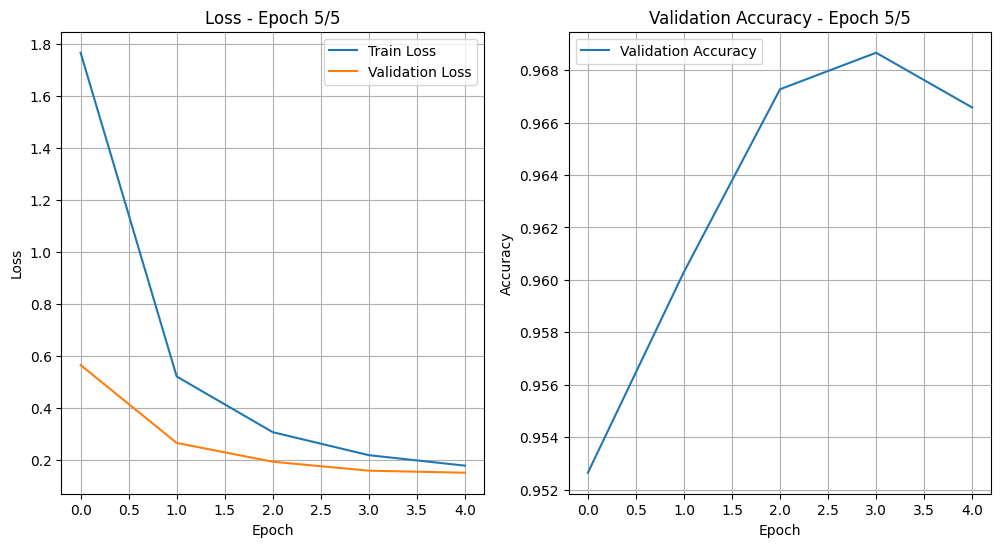

Epoch 5/5: Train Loss = 0.179, Validation Loss = 0.151, Validation Accuracy = 0.967


In [ ]:
train(
    eff_net,
    eff_net_opt,
    loss_fn,
    n_epochs,
    eff_net_loss_history,
    eff_net_val_acc_hist,
    eff_net_train_loader,
    eff_net_valid_loader,
    eff_net_best_model_params,
    "lab02_part05_eff_net_v2_s",
)

## EfficientNet-V2-S Prediction

In [102]:
load_only_trainable_checkpoint(
    eff_net, eff_net_opt, "/content/lab02_part05_eff_net_v2_s.pth"
)

<ipython-input-32-33c3f4500b2d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


(5,
 {'train': [1.7669940136698112,
   0.5215180131985463,
   0.30734089442364626,
   0.21890101898819156,
   0.1785964762197115],
  'valid': [0.565598526372883,
   0.26596365541136696,
   0.19369895021563452,
   0.1592294345493104,
   0.15139942439817786]})

In [82]:
eff_net_preds = test(eff_net, eff_net_test_loader)
save_predictions_to_csv(eff_net_preds, "eff_net_predictions.csv")

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

## MobileNet-V3-Large Training

In [35]:
mob_net_params_to_update = []
for name, param in mob_net.named_parameters():
    if param.requires_grad == True:
        mob_net_params_to_update.append(param)
        print(name)

classifier.3.1.weight
classifier.3.1.bias
classifier.3.3.weight
classifier.3.3.bias
classifier.3.4.weight
classifier.3.4.bias
classifier.3.7.weight
classifier.3.7.bias


In [36]:
mob_net_opt = torch.optim.Adam(mob_net_params_to_update, lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

In [37]:
mob_net_loss_history = {"train": [], "valid": []}
mob_net_val_acc_hist = []
mob_net_best_model_params = {"valid_loss": float("inf"), "epoch": -1}

In [38]:
n_epochs = 10

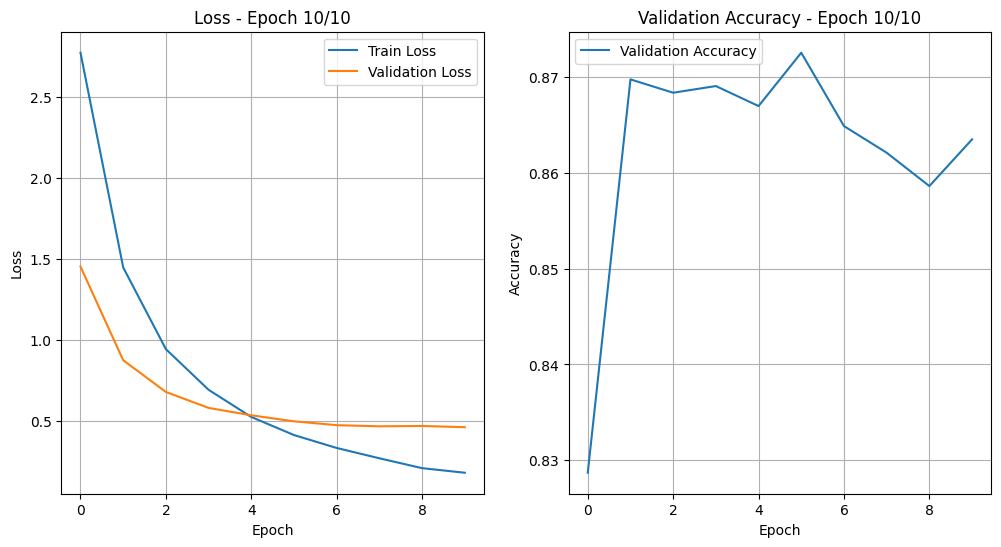

Epoch 10/10: Train Loss = 0.179, Validation Loss = 0.460, Validation Accuracy = 0.864


In [39]:
train(
    mob_net,
    mob_net_opt,
    loss_fn,
    n_epochs,
    mob_net_loss_history,
    mob_net_val_acc_hist,
    mob_net_train_loader,
    mob_net_valid_loader,
    mob_net_best_model_params,
    "lab02_part05_mob_net_v3_large",
)

## MobileNet-V3-Large Prediction

In [66]:
mob_net_preds = test(mob_net, mob_net_test_loader)
save_predictions_to_csv(mob_net_preds, "mob_net_predictions.csv")

Testing:   0%|          | 0/24 [00:00<?, ?it/s]